# Imports and Dependencies

In [ ]:
!pip install ucimlrepo

In [ ]:
# imports
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

# Let's make sure pandas returns all the rows and columns for the dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Set seaborn themes
import seaborn as sns
sns.set_theme(style='white')
sns.color_palette("mako", as_cmap=True)

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, WeightedRandomSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from tqdm import tqdm
#import torchsnooper  # remove before final submission

In [ ]:
# seeds for reproducibility (hopefully)
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Data Collection

In [ ]:
# fetching data from UCI ML repository

# fetch dataset
default_of_credit_card_clients = fetch_ucirepo(id=350)

# data (as pandas dataframes)
X = default_of_credit_card_clients.data.features
y = default_of_credit_card_clients.data.targets  # default payment (Yes = 1, No = 0)

# metadata
print(default_of_credit_card_clients.metadata)

# variable information
print(default_of_credit_card_clients.variables)

In [ ]:
# class imbalance
y.value_counts()

,count
Y,
0,23364
1,6636


# Feature Selection and Engineering

In [ ]:
categorical_features = {
        'X2': 'SEX',        # gender
        'X3': 'EDUCATION',  # edu
        'X4': 'MARRIAGE'    # marital status
    }

# scale numerical features
numerical_features = [
'X1',  # LIMIT_BAL
'X5'   # AGE
]

# payment history features; X6-X11 (already encoded but explicit for documentation)
payment_history = [f'X{i}' for i in range(6, 12)]

# bill amounts; cols X12-X17
bill_amounts = [f'X{i}' for i in range(12, 18)]

# payment amounts; cols X18-X23
payment_amounts = [f'X{i}' for i in range(18, 24)]

# combine all numerical features
all_numerical = numerical_features + bill_amounts + payment_amounts

# Flatten to prevent DataConversionWarning
y = np.ravel(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

scaler = StandardScaler()
X_train_processed[all_numerical] = scaler.fit_transform(X_train_processed[all_numerical])
X_test_processed[all_numerical] = scaler.transform(X_test_processed[all_numerical])

In [ ]:
# feature selection (used MI instead of Boruta because MI is easier to interpret)
threshold = 0.01 # initial value

mi_scores = mutual_info_classif(X_train_processed, y_train, random_state=42)
scores_df = pd.DataFrame({'feature': X_train_processed.columns,'mi_score': mi_scores}).sort_values('mi_score', ascending=False)

selected_features = scores_df[scores_df['mi_score'] > threshold]['feature'].tolist()

print("\nFeature Importance Scores:")
print(scores_df)


Feature Importance Scores:
   feature  mi_score
5       X6  0.078625
6       X7  0.050079
7       X8  0.037311
8       X9  0.033667
9      X10  0.030242
17     X18  0.026313
19     X20  0.022060
10     X11  0.020371
18     X19  0.016356
0       X1  0.015999
21     X22  0.015901
20     X21  0.014517
22     X23  0.009042
11     X12  0.008315
12     X13  0.006664
14     X15  0.006655
15     X16  0.006428
2       X3  0.005619
13     X14  0.003815
3       X4  0.002592
16     X17  0.002464
4       X5  0.001006
1       X2  0.000304


# Data Preprocessing

In [ ]:
# Create a selection of the top features
X_train_selected = X_train_processed[selected_features]
X_test_selected = X_test_processed[selected_features]

In [ ]:
X_t = torch.tensor(X.values, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, train_size=0.8, random_state=42)

In [ ]:
class CreditDataset(Dataset):
    def __init__(self):
        X_train = torch.tensor(X_train_selected.values, dtype=torch.float32)
        X_test = torch.tensor(X_test_selected.values, dtype=torch.float32)

        y_tr = y_train.clone().detach().reshape(-1, 1)  # works with CrossEntropyLoss
        y_te = y_test.clone().detach().reshape(-1, 1)  # works with CrossEntropyLoss

        # Load the training and testing dataset
        training_data, training_labels = X_train, y_tr
        test_data, test_labels = X_test, y_te
        # Record down the split point between train and test dataset
        self.train_test_split = len(training_labels)
        # Record down the overall dataset size
        self.size = len(training_labels) + len(test_labels)

        # Concatenate training and testing dataset
        self.data = torch.cat([training_data, test_data],dim=0)
        self.labels = torch.cat([training_labels, test_labels],dim=0)


    def __len__(self):
        '''
        This function returns the size of overall dataset
        '''
        return self.size


    def __getitem__(self, idx):
        '''
        This function extracts a single entry from the dataset at the given index idx
        '''
        return self.data[idx], self.labels[idx]

    def get_train_test_split(self):
        '''
        This function gets the train test split size of the dataset
        '''
        return self.train_test_split

# Model Building

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # This says if GPU is available, use GPU, otherwise use CPU
NUM_EPOCHS = 100
LEARNING_RATE = .001
BATCH_SIZE = 500

In [ ]:
def set_up_classifier():
    classifier = MLP()  # define binary classifier
    classifier.to(DEVICE)  # send the classifier to DEVICE as defined earlier

    print("# of params in model: ", sum(x.numel() for x in classifier.parameters()))

    criterion = nn.CrossEntropyLoss()
    criterion = criterion.to(DEVICE)

    # define the optimizer
    optimizer = optim.Adam(classifier.parameters(), lr=LEARNING_RATE)

    return classifier, criterion, optimizer

# Model Training & Test

In [ ]:
# Import the dataloader utilities
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler, WeightedRandomSampler

def get_dataloader():
    dataset = CreditDataset()
    # Get the indices of train dataset and test dataset correspondingly, indices [0:train_test_split] are the training dataset, indices [train_test_split, len(dataset)] are the test dataset.
    train_test_split = dataset.get_train_test_split()
    train_indices, val_indices = list(range(train_test_split)), list(range(train_test_split,len(dataset)))

    # Shuffle the two index lists
    np.random.shuffle(train_indices)
    np.random.shuffle(val_indices)

    # Define two subset random samplers to sample events according to the training indices
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    # weighted sampler
    labels = dataset.labels.squeeze(1)
    # Convert labels to integers before torch.bincount
    labels = labels.type(torch.int64)
    class_counts = torch.bincount(labels)
    weights = 1. / class_counts.float()
    weight_train_sampler = WeightedRandomSampler(weights[labels], len(train_indices))
    weight_valid_sampler = WeightedRandomSampler(weights[labels], len(val_indices))

    # Finally, define the loader by passing in the dataset, batch size and corresponding sampler
    # Note that the number of data in each sub-dataset might not be divisible by the batch size, so drop_last=True drops the last batch with all the residual events.
    train_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=weight_train_sampler, drop_last=True)  # train on balanced data
    test_loader = data_utils.DataLoader(dataset, batch_size=BATCH_SIZE,sampler=valid_sampler,  drop_last=True)  # test on unbalanced data

    return train_loader, test_loader


In [ ]:
#######
class MLP(torch.nn.Module):
  def __init__(self):
    super(MLP, self).__init__()

    self.classif = nn.Sequential(
      nn.Linear(12, 128),
      nn.LeakyReLU(),

      nn.Linear(128, 128),
      nn.LeakyReLU(),

      nn.Linear(128, 64),
      nn.LeakyReLU(),
      nn.Dropout(p=0.1),

      nn.Linear(64, 32),
      nn.LeakyReLU(),
      nn.Linear(32, 2),
      )

  def forward(self, x):
    # DO: define the feedforward algorithm of the model and return the final output
    x = self.classif(x)
    return x
#######

In [ ]:
## for testing with torchsnooper
# pull out one event from the dataset
test_event, test_label = next(iter(CreditDataset()))
test_event = test_event.unsqueeze(0).float()  # dummy batch dimension
print(len(test_event[0]))
test_network = MLP()
print(test_network(test_event))
print(test_label)

12
tensor([[-0.0649, -0.1917]], grad_fn=<AddmmBackward0>)
tensor([0.])


In [ ]:
classifier, criterion, optimizer = set_up_classifier()
train_loader, test_loader = get_dataloader()

loss_values = []
accuracy_values = []
y_true = []
y_pred = []

for epoch in range(NUM_EPOCHS):
    for i, (data, labels) in tqdm(enumerate(train_loader)):
    #for i, (data, labels) in enumerate(train_loader):
        classifier.train() # This line set the neural network to train mode, some layers perform differently in train and test mode.

        data = data.to(DEVICE).float()
        #labels = labels.to(DEVICE)  # works for BCE loss
        labels = labels.squeeze(1).to(DEVICE).long() # Cast labels to long

        #Train the CNN classifier
        outputs  = classifier(data)
        #print(outputs.shape, labels.squeeze(1).shape)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Back-propagate loss to update gradient
        loss.backward()

        # Perform gradient descent to update parameters
        optimizer.step()

        # reset gradient to 0 on all parameters
        optimizer.zero_grad()

    #if epoch%5==0:
    print('\rEpoch [{0}/{1}], Iter [{2}/{3}], Loss: {4:.4f}'.format(
        epoch+1, NUM_EPOCHS, i+1, len(train_loader),
        loss.item(), end=""),end="")
    loss_values.append(loss.item())

    #After every epoch, evaluate the validation accuracy on the test loader
    num_accurate = 0
    num_data = 0
    for data,labels in tqdm(test_loader):
    #for data,labels in test_loader:

        classifier.eval() # This line set the neural network to evaluation mode, some layers perform differently in train and test mode.

        #While validating the network, we do not want it to produce any gradient. This will also save us time/memory
        with torch.no_grad():

            # Convey images to device, then feed it to the neural network for network output
            data = data.to(DEVICE).float()
            outputs  = classifier(data)

            # Get classification decision by reading out the maximum value on the 10-dimensional vector
            decision = torch.argmax(outputs, dim=-1)
            decision = decision.cpu().data.numpy().flatten() # copy decision to CPU and convert it to a numpy array
            labels = labels.cpu().data.numpy().flatten()

            # Update the list of truth value and network predictions in last epoch:
            if epoch == (NUM_EPOCHS-1):
                y_true += list(labels)
                y_pred += list(decision)

            #Calculate accuracy by # of correct prediction / total numbers

            num_accurate += np.sum((decision - labels) == 0)
            num_data += len(decision)
    accuracy_values.append(num_accurate/num_data)

# of params in model:  28578


48it [00:00, 117.61it/s]


Epoch [1/100], Iter [48/48], Loss: 0.5781

100%|██████████| 12/12 [00:00<00:00, 228.84it/s]
48it [00:00, 218.90it/s]


Epoch [2/100], Iter [48/48], Loss: 0.5838

100%|██████████| 12/12 [00:00<00:00, 253.17it/s]
48it [00:00, 217.50it/s]


Epoch [3/100], Iter [48/48], Loss: 0.5971

100%|██████████| 12/12 [00:00<00:00, 253.04it/s]
48it [00:00, 205.20it/s]


Epoch [4/100], Iter [48/48], Loss: 0.5518

100%|██████████| 12/12 [00:00<00:00, 215.09it/s]
48it [00:00, 117.68it/s]


Epoch [5/100], Iter [48/48], Loss: 0.5677

100%|██████████| 12/12 [00:00<00:00, 228.59it/s]
48it [00:00, 216.66it/s]


Epoch [6/100], Iter [48/48], Loss: 0.5744

100%|██████████| 12/12 [00:00<00:00, 234.59it/s]
48it [00:00, 209.35it/s]


Epoch [7/100], Iter [48/48], Loss: 0.5500

100%|██████████| 12/12 [00:00<00:00, 172.22it/s]
48it [00:00, 210.16it/s]


Epoch [8/100], Iter [48/48], Loss: 0.5583

100%|██████████| 12/12 [00:00<00:00, 243.40it/s]
48it [00:00, 217.98it/s]


Epoch [9/100], Iter [48/48], Loss: 0.5234

100%|██████████| 12/12 [00:00<00:00, 254.63it/s]
48it [00:00, 157.96it/s]


Epoch [10/100], Iter [48/48], Loss: 0.5998

100%|██████████| 12/12 [00:00<00:00, 113.53it/s]
48it [00:00, 92.26it/s]


Epoch [11/100], Iter [48/48], Loss: 0.5706

100%|██████████| 12/12 [00:00<00:00, 157.80it/s]
48it [00:00, 144.04it/s]


Epoch [12/100], Iter [48/48], Loss: 0.5256

100%|██████████| 12/12 [00:00<00:00, 142.10it/s]
48it [00:00, 140.62it/s]


Epoch [13/100], Iter [48/48], Loss: 0.5480

100%|██████████| 12/12 [00:00<00:00, 150.68it/s]
48it [00:00, 137.74it/s]


Epoch [14/100], Iter [48/48], Loss: 0.5403

100%|██████████| 12/12 [00:00<00:00, 132.65it/s]
48it [00:00, 130.22it/s]


Epoch [15/100], Iter [48/48], Loss: 0.5299

100%|██████████| 12/12 [00:00<00:00, 58.26it/s]
48it [00:00, 219.89it/s]


Epoch [16/100], Iter [48/48], Loss: 0.5582

100%|██████████| 12/12 [00:00<00:00, 223.52it/s]
48it [00:00, 188.35it/s]


Epoch [17/100], Iter [48/48], Loss: 0.6020

100%|██████████| 12/12 [00:00<00:00, 240.06it/s]
48it [00:00, 218.08it/s]


Epoch [18/100], Iter [48/48], Loss: 0.5336

100%|██████████| 12/12 [00:00<00:00, 255.36it/s]
48it [00:00, 217.34it/s]


Epoch [19/100], Iter [48/48], Loss: 0.5631

100%|██████████| 12/12 [00:00<00:00, 56.52it/s]
48it [00:00, 183.52it/s]


Epoch [20/100], Iter [48/48], Loss: 0.5359

100%|██████████| 12/12 [00:00<00:00, 243.06it/s]
48it [00:00, 215.94it/s]


Epoch [21/100], Iter [48/48], Loss: 0.5746

100%|██████████| 12/12 [00:00<00:00, 234.11it/s]
48it [00:00, 221.71it/s]


Epoch [22/100], Iter [48/48], Loss: 0.4981

100%|██████████| 12/12 [00:00<00:00, 246.50it/s]
48it [00:00, 196.68it/s]


Epoch [23/100], Iter [48/48], Loss: 0.5493

100%|██████████| 12/12 [00:00<00:00, 180.94it/s]
48it [00:00, 213.77it/s]


Epoch [24/100], Iter [48/48], Loss: 0.5422

100%|██████████| 12/12 [00:00<00:00, 248.02it/s]
48it [00:00, 221.58it/s]


Epoch [25/100], Iter [48/48], Loss: 0.5707

100%|██████████| 12/12 [00:00<00:00, 234.11it/s]
48it [00:00, 114.44it/s]


Epoch [26/100], Iter [48/48], Loss: 0.5740

100%|██████████| 12/12 [00:00<00:00, 253.19it/s]
48it [00:00, 210.43it/s]


Epoch [27/100], Iter [48/48], Loss: 0.5480

100%|██████████| 12/12 [00:00<00:00, 251.80it/s]
48it [00:00, 223.39it/s]


Epoch [28/100], Iter [48/48], Loss: 0.5374

100%|██████████| 12/12 [00:00<00:00, 147.53it/s]
48it [00:00, 208.88it/s]


Epoch [29/100], Iter [48/48], Loss: 0.5716

100%|██████████| 12/12 [00:00<00:00, 155.05it/s]
48it [00:00, 125.98it/s]


Epoch [30/100], Iter [48/48], Loss: 0.5023

100%|██████████| 12/12 [00:00<00:00, 260.34it/s]
48it [00:00, 218.73it/s]


Epoch [31/100], Iter [48/48], Loss: 0.5544

100%|██████████| 12/12 [00:00<00:00, 252.95it/s]
48it [00:00, 202.37it/s]


Epoch [32/100], Iter [48/48], Loss: 0.5664

100%|██████████| 12/12 [00:00<00:00, 182.98it/s]
48it [00:00, 219.62it/s]


Epoch [33/100], Iter [48/48], Loss: 0.5339

100%|██████████| 12/12 [00:00<00:00, 249.13it/s]
48it [00:00, 217.73it/s]


Epoch [34/100], Iter [48/48], Loss: 0.5235

100%|██████████| 12/12 [00:00<00:00, 250.59it/s]
48it [00:00, 216.42it/s]


Epoch [35/100], Iter [48/48], Loss: 0.5310

100%|██████████| 12/12 [00:00<00:00, 228.72it/s]
48it [00:00, 112.82it/s]


Epoch [36/100], Iter [48/48], Loss: 0.5130

100%|██████████| 12/12 [00:00<00:00, 242.68it/s]
48it [00:00, 217.36it/s]


Epoch [37/100], Iter [48/48], Loss: 0.5737

100%|██████████| 12/12 [00:00<00:00, 251.25it/s]
48it [00:00, 214.42it/s]


Epoch [38/100], Iter [48/48], Loss: 0.5153

100%|██████████| 12/12 [00:00<00:00, 183.51it/s]
48it [00:00, 203.38it/s]


Epoch [39/100], Iter [48/48], Loss: 0.5064

100%|██████████| 12/12 [00:00<00:00, 252.04it/s]
48it [00:00, 129.88it/s]


Epoch [40/100], Iter [48/48], Loss: 0.5318

100%|██████████| 12/12 [00:00<00:00, 240.98it/s]
48it [00:00, 203.67it/s]


Epoch [41/100], Iter [48/48], Loss: 0.5080

100%|██████████| 12/12 [00:00<00:00, 194.52it/s]
48it [00:00, 210.05it/s]


Epoch [42/100], Iter [48/48], Loss: 0.5251

100%|██████████| 12/12 [00:00<00:00, 241.58it/s]
48it [00:00, 220.37it/s]


Epoch [43/100], Iter [48/48], Loss: 0.4904

100%|██████████| 12/12 [00:00<00:00, 251.04it/s]
48it [00:00, 213.61it/s]


Epoch [44/100], Iter [48/48], Loss: 0.4974

100%|██████████| 12/12 [00:00<00:00, 235.48it/s]
48it [00:00, 188.43it/s]


Epoch [45/100], Iter [48/48], Loss: 0.5536

100%|██████████| 12/12 [00:00<00:00, 238.03it/s]
48it [00:00, 159.96it/s]


Epoch [46/100], Iter [48/48], Loss: 0.5018

100%|██████████| 12/12 [00:00<00:00, 42.91it/s]
48it [00:00, 132.53it/s]


Epoch [47/100], Iter [48/48], Loss: 0.4877

100%|██████████| 12/12 [00:00<00:00, 155.22it/s]
48it [00:00, 158.51it/s]


Epoch [48/100], Iter [48/48], Loss: 0.5148

100%|██████████| 12/12 [00:00<00:00, 165.84it/s]
48it [00:00, 131.27it/s]


Epoch [49/100], Iter [48/48], Loss: 0.4842

100%|██████████| 12/12 [00:00<00:00, 135.63it/s]
48it [00:00, 136.29it/s]


Epoch [50/100], Iter [48/48], Loss: 0.4946

100%|██████████| 12/12 [00:00<00:00, 153.44it/s]
48it [00:00, 144.14it/s]


Epoch [51/100], Iter [48/48], Loss: 0.4655

100%|██████████| 12/12 [00:00<00:00, 150.77it/s]
48it [00:00, 141.10it/s]


Epoch [52/100], Iter [48/48], Loss: 0.5288

100%|██████████| 12/12 [00:00<00:00, 58.47it/s]
48it [00:00, 218.44it/s]


Epoch [53/100], Iter [48/48], Loss: 0.5083

100%|██████████| 12/12 [00:00<00:00, 238.80it/s]
48it [00:00, 186.56it/s]


Epoch [54/100], Iter [48/48], Loss: 0.4826

100%|██████████| 12/12 [00:00<00:00, 228.58it/s]
48it [00:00, 208.59it/s]


Epoch [55/100], Iter [48/48], Loss: 0.5245

100%|██████████| 12/12 [00:00<00:00, 240.94it/s]
48it [00:00, 215.18it/s]


Epoch [56/100], Iter [48/48], Loss: 0.5142

100%|██████████| 12/12 [00:00<00:00, 241.41it/s]
48it [00:00, 118.07it/s]


Epoch [57/100], Iter [48/48], Loss: 0.4630

100%|██████████| 12/12 [00:00<00:00, 250.87it/s]
48it [00:00, 205.24it/s]


Epoch [58/100], Iter [48/48], Loss: 0.4714

100%|██████████| 12/12 [00:00<00:00, 242.78it/s]
48it [00:00, 216.55it/s]


Epoch [59/100], Iter [48/48], Loss: 0.5187

100%|██████████| 12/12 [00:00<00:00, 223.50it/s]
48it [00:00, 190.35it/s]


Epoch [60/100], Iter [48/48], Loss: 0.5096

100%|██████████| 12/12 [00:00<00:00, 236.01it/s]
48it [00:00, 215.06it/s]


Epoch [61/100], Iter [48/48], Loss: 0.4949

100%|██████████| 12/12 [00:00<00:00, 197.78it/s]
48it [00:00, 214.81it/s]


Epoch [62/100], Iter [48/48], Loss: 0.5078

100%|██████████| 12/12 [00:00<00:00, 229.82it/s]
48it [00:00, 117.29it/s]


Epoch [63/100], Iter [48/48], Loss: 0.4777

100%|██████████| 12/12 [00:00<00:00, 233.49it/s]
48it [00:00, 210.72it/s]


Epoch [64/100], Iter [48/48], Loss: 0.4561

100%|██████████| 12/12 [00:00<00:00, 226.70it/s]
48it [00:00, 219.02it/s]


Epoch [65/100], Iter [48/48], Loss: 0.5497

100%|██████████| 12/12 [00:00<00:00, 228.96it/s]
48it [00:00, 196.58it/s]


Epoch [66/100], Iter [48/48], Loss: 0.4888

100%|██████████| 12/12 [00:00<00:00, 194.77it/s]
48it [00:00, 124.29it/s]


Epoch [67/100], Iter [48/48], Loss: 0.5019

100%|██████████| 12/12 [00:00<00:00, 255.89it/s]
48it [00:00, 221.06it/s]


Epoch [68/100], Iter [48/48], Loss: 0.4891

100%|██████████| 12/12 [00:00<00:00, 220.81it/s]
48it [00:00, 200.99it/s]


Epoch [69/100], Iter [48/48], Loss: 0.4721

100%|██████████| 12/12 [00:00<00:00, 198.54it/s]
48it [00:00, 215.99it/s]


Epoch [70/100], Iter [48/48], Loss: 0.5056

100%|██████████| 12/12 [00:00<00:00, 230.54it/s]
48it [00:00, 205.16it/s]


Epoch [71/100], Iter [48/48], Loss: 0.5009

100%|██████████| 12/12 [00:00<00:00, 235.02it/s]
48it [00:00, 207.13it/s]


Epoch [72/100], Iter [48/48], Loss: 0.5145

100%|██████████| 12/12 [00:00<00:00, 193.79it/s]
48it [00:00, 121.93it/s]


Epoch [73/100], Iter [48/48], Loss: 0.4728

100%|██████████| 12/12 [00:00<00:00, 244.14it/s]
48it [00:00, 201.57it/s]


Epoch [74/100], Iter [48/48], Loss: 0.4683

100%|██████████| 12/12 [00:00<00:00, 241.28it/s]
48it [00:00, 196.15it/s]


Epoch [75/100], Iter [48/48], Loss: 0.4480

100%|██████████| 12/12 [00:00<00:00, 240.81it/s]
48it [00:00, 213.86it/s]


Epoch [76/100], Iter [48/48], Loss: 0.4997

100%|██████████| 12/12 [00:00<00:00, 234.39it/s]
48it [00:00, 210.14it/s]


Epoch [77/100], Iter [48/48], Loss: 0.4830

100%|██████████| 12/12 [00:00<00:00, 55.67it/s]
48it [00:00, 192.16it/s]


Epoch [78/100], Iter [48/48], Loss: 0.4635

100%|██████████| 12/12 [00:00<00:00, 221.54it/s]
48it [00:00, 214.93it/s]


Epoch [79/100], Iter [48/48], Loss: 0.4544

100%|██████████| 12/12 [00:00<00:00, 231.01it/s]
48it [00:00, 213.74it/s]


Epoch [80/100], Iter [48/48], Loss: 0.4857

100%|██████████| 12/12 [00:00<00:00, 239.17it/s]
48it [00:00, 206.24it/s]


Epoch [81/100], Iter [48/48], Loss: 0.4524

100%|██████████| 12/12 [00:00<00:00, 188.30it/s]
48it [00:00, 204.49it/s]


Epoch [82/100], Iter [48/48], Loss: 0.4640

100%|██████████| 12/12 [00:00<00:00, 232.74it/s]
48it [00:00, 140.22it/s]


Epoch [83/100], Iter [48/48], Loss: 0.4733

100%|██████████| 12/12 [00:00<00:00, 157.27it/s]
48it [00:00, 89.63it/s]


Epoch [84/100], Iter [48/48], Loss: 0.4806

100%|██████████| 12/12 [00:00<00:00, 168.23it/s]
48it [00:00, 146.39it/s]


Epoch [85/100], Iter [48/48], Loss: 0.5108

100%|██████████| 12/12 [00:00<00:00, 157.31it/s]
48it [00:00, 127.63it/s]


Epoch [86/100], Iter [48/48], Loss: 0.4456

100%|██████████| 12/12 [00:00<00:00, 148.71it/s]
48it [00:00, 142.16it/s]


Epoch [87/100], Iter [48/48], Loss: 0.4672

100%|██████████| 12/12 [00:00<00:00, 124.05it/s]
48it [00:00, 86.71it/s]


Epoch [88/100], Iter [48/48], Loss: 0.4691

100%|██████████| 12/12 [00:00<00:00, 224.54it/s]
48it [00:00, 214.94it/s]


Epoch [89/100], Iter [48/48], Loss: 0.4798

100%|██████████| 12/12 [00:00<00:00, 262.92it/s]
48it [00:00, 206.83it/s]


Epoch [90/100], Iter [48/48], Loss: 0.4710

100%|██████████| 12/12 [00:00<00:00, 242.04it/s]
48it [00:00, 192.34it/s]


Epoch [91/100], Iter [48/48], Loss: 0.4350

100%|██████████| 12/12 [00:00<00:00, 233.30it/s]
48it [00:00, 213.66it/s]


Epoch [92/100], Iter [48/48], Loss: 0.4837

100%|██████████| 12/12 [00:00<00:00, 207.95it/s]
48it [00:00, 203.50it/s]


Epoch [93/100], Iter [48/48], Loss: 0.4471

100%|██████████| 12/12 [00:00<00:00, 231.52it/s]
48it [00:00, 116.92it/s]


Epoch [94/100], Iter [48/48], Loss: 0.4403

100%|██████████| 12/12 [00:00<00:00, 244.06it/s]
48it [00:00, 217.36it/s]


Epoch [95/100], Iter [48/48], Loss: 0.4879

100%|██████████| 12/12 [00:00<00:00, 238.96it/s]
48it [00:00, 209.99it/s]


Epoch [96/100], Iter [48/48], Loss: 0.4500

100%|██████████| 12/12 [00:00<00:00, 214.81it/s]
48it [00:00, 196.74it/s]


Epoch [97/100], Iter [48/48], Loss: 0.4569

100%|██████████| 12/12 [00:00<00:00, 233.86it/s]
48it [00:00, 127.88it/s]


Epoch [98/100], Iter [48/48], Loss: 0.4519

100%|██████████| 12/12 [00:00<00:00, 243.72it/s]
48it [00:00, 206.58it/s]


Epoch [99/100], Iter [48/48], Loss: 0.4684

100%|██████████| 12/12 [00:00<00:00, 214.43it/s]
48it [00:00, 198.04it/s]


Epoch [100/100], Iter [48/48], Loss: 0.4877

100%|██████████| 12/12 [00:00<00:00, 216.62it/s]


# Visualizations

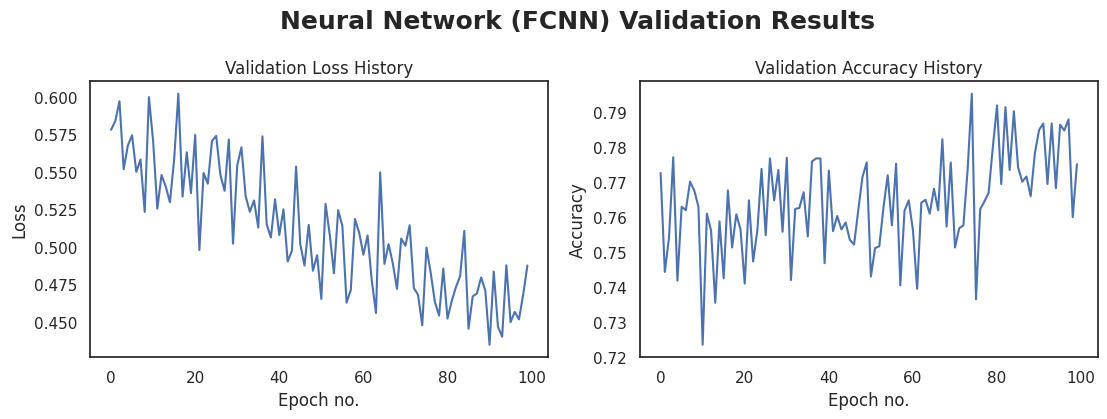

In [ ]:
# plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

fig.suptitle('Neural Network (FCNN) Validation Results', fontsize=18, fontweight='bold')
fig.subplots_adjust(top=0.8)
ax[0].plot(np.arange(NUM_EPOCHS).astype(int), loss_values)
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(np.arange(NUM_EPOCHS).astype(int), np.array(accuracy_values))
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy')

plt.show()

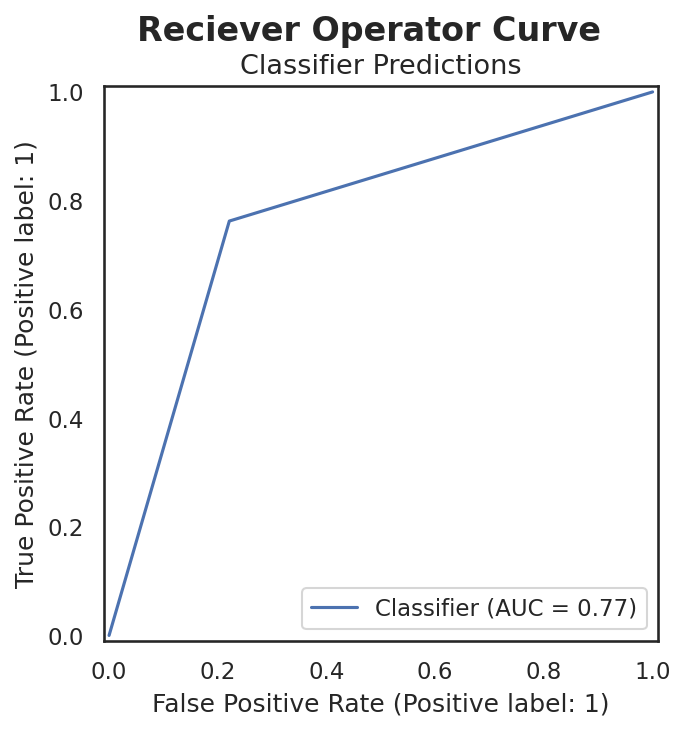

In [ ]:
fig = plt.figure(dpi=150)
ax = plt.gca()
RocCurveDisplay.from_predictions(y_true, y_pred, name="Classifier", ax=ax)
fig.suptitle('Reciever Operator Curve', fontsize=16, fontweight='bold')
ax.set_title('Classifier Predictions', fontsize=13)
ax.set_xlabel('False Positive Rate (Positive label: 1)', fontsize = 12)
ax.set_ylabel('True Positive Rate (Positive label: 1)', fontsize=12)
plt.show()

Classification Report
               precision    recall  f1-score   support

         0.0       0.92      0.78      0.84      4687
         1.0       0.49      0.76      0.60      1313

    accuracy                           0.78      6000
   macro avg       0.71      0.77      0.72      6000
weighted avg       0.83      0.78      0.79      6000



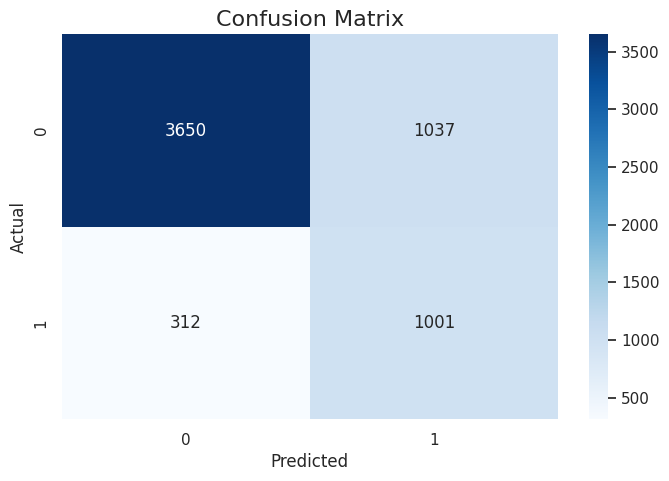

In [ ]:
# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Classification Report\n", classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize = (8, 5))
sns.heatmap(cm, annot = True,
            fmt = '.0f',
            cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix', fontsize=16)
plt.show()